In [ ]:
import os

import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf

from keras.models import load_model
from keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, Flatten,Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
from PIL import Image
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [ ]:

batch_size=128


# Load the CIFAR-10 dataset

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
# X_train = tf.image.resize(X_train, (224, 224))
# X_test = tf.image.resize(X_test, (224, 224))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255
X_test /= 255
x_val = X_train[40000:]
y_val = y_train[40000:]
x_train = X_train[:40000]
y_train = y_train[:40000]

# # Split the dataset into training and testing sets
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
# from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

base_model = VGG16(weights='imagenet', include_top=False, classes=10,input_shape=(32, 32, 3))

# Freeze the pre-trained layers
model1 = models.Sequential()
# model.add(layers.experimental.preprocessing.Resizing(64, 64))
for layer in base_model.layers:
    model1.add(layer)

model1.add(Flatten())
model1.add(Dense(512, activation='relu', name='hidden1'))
model1.add(Dropout(0.4))
model1.add(Dense(256, activation='relu', name='hidden2'))
model1.add(Dropout(0.4))
model1.add(Dense(10, activation='softmax', name='predictions'))

sgd = optimizers.SGD(lr=0.001, momentum=0.9)

# For a multi-class classification problem
model1.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])


# model.fit(x_train,y_train,epochs=40,validation_data=(x_val,y_val),batch_size=batch_size)


58889256/58889256 [==============================] - 1s 0us/step


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# model.save('/content/drive/MyDrive/puja_phd/model_vgg16_raw_32 data.h5')

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/puja_phd/vgg16_cifar10_raw.h5')
model1=tf.keras.models.load_model('/content/drive/MyDrive/puja_phd/model_vgg16_raw_adverserial_training.h5')
model2=tf.keras.models.load_model('/content/drive/MyDrive/puja_phd/model_vgg16_raw_gradcam_training.h5')

In [ ]:
# Evaluate the model

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")
test_loss, test_acc = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

313/313 [==============================] - 6s 9ms/step - loss: 0.4185 - accuracy: 0.8797
Test Accuracy: 0.8797000050544739
313/313 [==============================] - 3s 8ms/step - loss: 0.9997 - accuracy: 0.7814
Test Accuracy: 0.7814000248908997
313/313 [==============================] - 3s 8ms/step - loss: 2.7133 - accuracy: 0.6974
Test Accuracy: 0.6973999738693237


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [ ]:

def generate_fgsm_attack(image, epsilon, model):


    # Convert image to a tensor
    image_tensor = tf.convert_to_tensor(image[np.newaxis, ...], dtype=tf.float32)

    # Create a tensor for gradient tape
    image_tensor = tf.Variable(image_tensor)

    # Record gradients using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy([np.argmax(predictions)], predictions)

    # Calculate gradients
    gradients = tape.gradient(loss, image_tensor)

    # Calculate the sign of the gradients
    signed_gradients = tf.sign(gradients)

    # Create the perturbed image
    adversarial_image = image_tensor + epsilon * signed_gradients

    adversarial_image = adversarial_image.numpy()

    return adversarial_image[0]

In [ ]:
import matplotlib.cm as cm
def make_gradcam_heatmap(img_array, model, layerName='block4_conv3'):

    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layerName).output, model.output])
    img_array = np.expand_dims(img_array,axis=0)
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # if pred_index is None:
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds
def gradCAMImage(image,model,layerName='block4_conv3'):
    img=image

    heatmap,preds = make_gradcam_heatmap(image,model,layerName,)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(np.uint8(255*img), 0.5, heatmap, 0.5, 0)
    # gradcam = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)


    return superimposed_img

5it [00:02,  2.62it/s]

5 6 6


5it [00:02,  1.79it/s]


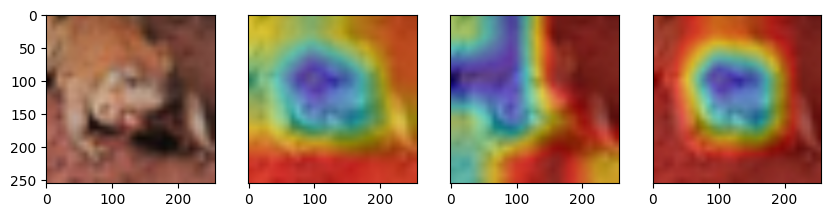

In [ ]:
from tqdm import tqdm
import cv2
import pandas as pd
epsilon=[.01]

def preprocess_image(img_array):

    img_array = np.expand_dims(img_array*255, axis=0)
    # img_array = vgg16_preprocess(img_array)

    return img_array

# Function to make predictions on a single image
def predict_single_image(image_path):
    processed_image = preprocess_image(image_path)
    # print(processed_image[0].shape)
    predictions = model.predict(processed_image,verbose=0)
    return predictions

df3=pd.DataFrame()
df4=pd.DataFrame()
df5=pd.DataFrame()
for i in epsilon:
  actual,pred=[],[]
  raw = []
  adv=[]
  grad=[]
  labels = []


    # Generate perturbed images for all test data

  for image, label in tqdm(zip(X_test, y_test)):

      # print(label)
      # print(image.shape,label.shape)
      perturbed_image = generate_fgsm_attack(image, epsilon=i, model=model)
      # print(perturbed_image.shape)
      perturbed_image= preprocess_image(perturbed_image)
      # y_pred_1=model1.predict(perturbed_image,verbose=0)
      # perturbed_image = generate_fgsm_attack(image, epsilon=i, model=model)
      # # print(perturbed_image.shape)
      # perturbed_image= preprocess_image(perturbed_image)
      # y_pred_1=model1.predict(perturbed_image,verbose=0)

      pred_class=model.predict(perturbed_image,verbose=0).argmax(axis=1)[0]
      pred_class_af=model2.predict(perturbed_image,verbose=0).argmax(axis=1)[0]

      if pred_class!=np.argmax(label) and pred_class_af==np.argmax(label):
            print(pred_class,np.argmax(label),pred_class_af)
            fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(10,12))
            super_=gradCAMImage(image,model,layerName='block4_conv3')
            raw_=gradCAMImage(perturbed_image.squeeze()/255.0,model,layerName='block4_conv3')
            after_=gradCAMImage(perturbed_image.squeeze()/255.0,model2,layerName='block4_conv3')
            super_ = cv2.resize(super_,(256, 256), interpolation=cv2.INTER_LINEAR)
            raw_ = cv2.resize(raw_, (256, 256), interpolation=cv2.INTER_LINEAR)
            after_ = cv2.resize(after_, (256, 256), interpolation=cv2.INTER_LINEAR)
            ax[0].imshow(cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR))
            ax[1].imshow(super_)
            ax[2].imshow(raw_)
            ax[3].imshow(after_)
            ax[1].set_yticks([])
            ax[2].set_yticks([])
            ax[3].set_yticks([])
            # ax[0].set_title('original image')
            # ax[1].set_title('')
            break
            # plt.plot(super_)

      # raw.append(model.predict(perturbed_image,verbose=0).argmax(axis=1)[0])
      # adv.append(model1.predict(perturbed_image,verbose=0).argmax(axis=1)[0])
      # grad.append(model2.predict(perturbed_image,verbose=0).argmax(axis=1)[0])
      # print(y_pred_1.argmax(axis=1)[0],np.argmax(label))

      # print(y_pred_1.argmax(axis=1),np.argmax(label))
      # labels.append(np.argmax(label))
  # df=pd.DataFrame(confusion_matrix(raw, labels))
  # df1=pd.DataFrame(confusion_matrix(adv, labels))
  # df2=pd.DataFrame(confusion_matrix(grad, labels))
  # print(df)
  # # break




  # df3=pd.concat([df3,df],axis=0)
  # df4=pd.concat([df1,df],axis=0)
  # df5=pd.concat([df2,df],axis=0)


# df3.to_csv('/content/drive/MyDrive/puja_phd/result_confusion_matrix_model_raw.csv')
# df3.to_csv('/content/drive/MyDrive/puja_phd/result_confusion_matrix_model_adv.csv')

# df3.to_csv('/content/drive/MyDrive/puja_phd/result_confusion_matrix_model_arad.csv')



In [ ]:
fter_=gradCAMImage(X_test[5],model2,layerName='block4_conv3')

1
1


[]

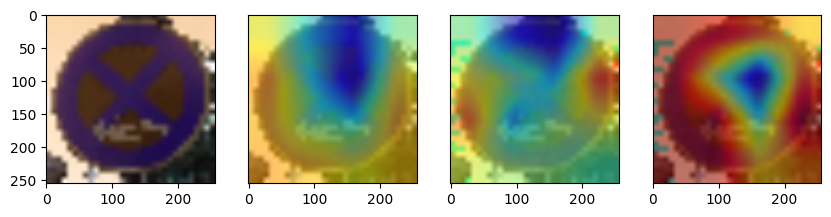

In [ ]:
image = cv2.imread('/content/20_00681.jpg')
image=cv2.resize(image, (32, 32), interpolation=cv2.INTER_LINEAR)
# Convert the image to an array
image_array = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
perturbed_image = generate_fgsm_attack(image/255.0, epsilon=0.01, model=model)
# print(perturbed_image.shape)
perturbed_image= preprocess_image(perturbed_image)
# y_pred_1=model1.predict(perturbed_image,verbose=0)
# perturbed_image = generate_fgsm_attack(image, epsilon=i, model=model)
# # print(perturbed_image.shape)
# perturbed_image= preprocess_image(perturbed_image)
# y_pred_1=model1.predict(perturbed_image,verbose=0)

pred_class=model.predict(perturbed_image,verbose=0).argmax(axis=1)[0]
pred_class_af=model2.predict(perturbed_image,verbose=0).argmax(axis=1)[0]
print(pred_class)
print(pred_class_af)
# if pred_class!=np.argmax(label) and pred_class_af==np.argmax(label):
# print(pred_class,np.argmax(label),pred_class_af)
fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(10,12))
super_=gradCAMImage(image/255.0,model,layerName='block4_conv3')
raw_=gradCAMImage(perturbed_image.squeeze()/255.0,model,layerName='block4_conv3')
after_=gradCAMImage(perturbed_image.squeeze()/255.0,model2,layerName='block4_conv3')
super_ = cv2.resize(super_,(256, 256), interpolation=cv2.INTER_LINEAR)
raw_ = cv2.resize(raw_, (256, 256), interpolation=cv2.INTER_LINEAR)
after_ = cv2.resize(after_, (256, 256), interpolation=cv2.INTER_LINEAR)
ax[0].imshow(cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR))
ax[1].imshow(super_)
ax[2].imshow(raw_)
ax[3].imshow(after_)
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])
      # ax[0].set_title('original image')
      # ax[1].set_title('')


In [ ]:
perturbed_image = generate_fgsm_attack(X_test[5], epsilon=0.01, model=model)
# print(perturbed_image.shape)
perturbed_image= preprocess_image(perturbed_image)

In [ ]:
perturbed_image

array([[[[176.45001 , 120.549995,  80.450005],
         [136.45001 ,  98.55    ,  63.550003],
         [ 74.450005,  51.550003,  28.55    ],
         ...,
         [ 84.450005,  50.45    ,  43.45    ],
         [ 73.450005,  44.45    ,  38.45    ],
         [ 74.450005,  49.550003,  38.45    ]],

        [[181.45001 , 132.55    ,  94.450005],
         [130.45001 ,  90.55    ,  50.45    ],
         [125.45001 ,  91.55    ,  60.550003],
         ...,
         [100.55    ,  63.550003,  55.550003],
         [ 88.450005,  60.550003,  53.550003],
         [ 92.55    ,  59.550003,  51.550003]],

        [[177.45001 , 134.55    , 102.549995],
         [149.45001 , 101.450005,  68.450005],
         [173.45001 , 126.45001 ,  89.450005],
         ...,
         [103.549995,  64.55    ,  55.550003],
         [ 90.450005,  58.550003,  49.550003],
         [ 92.450005,  59.550003,  51.550003]],

        ...,

        [[139.45001 ,  70.450005,  58.449997],
         [146.45001 ,  86.55    ,  72.450005]

In [ ]:
after_=gradCAMImage(perturbed_image.squeeze()/255.0,model2,layerName='block4_conv3')

array([[[160,  60,  40],
        [140,  49,  32],
        [109,  26,  14],
        ...,
        [106,  25,  22],
        [100,  22,  19],
        [101,  24,  19]],

       [[162,  66,  47],
        [137,  45,  25],
        [134,  46,  30],
        ...,
        [114,  32,  28],
        [108,  30,  26],
        [110,  30,  26]],

       [[160,  67,  51],
        [146,  50,  34],
        [158,  63,  44],
        ...,
        [116,  32,  28],
        [109,  29,  24],
        [110,  30,  26]],

       ...,

       [[154,  35,  29],
        [157,  43,  36],
        [157,  42,  38],
        ...,
        [122,  35,  26],
        [132,  42,  38],
        [142,  48,  43]],

       [[161,  42,  36],
        [168,  49,  42],
        [174,  54,  46],
        ...,
        [128,  40,  31],
        [134,  42,  37],
        [142,  46,  38]],

       [[164,  47,  40],
        [174,  54,  48],
        [174,  55,  46],
        ...,
        [138,  44,  36],
        [139,  44,  38],
        [141,  44,  38]]], dtype=uint8)
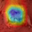

In [ ]:
after_

In [ ]:
from tqdm import tqdm
import pandas as pd
epsilon=[0.04,0.05]

def preprocess_image(img_array):

    img_array = np.expand_dims(img_array*255, axis=0)
    # img_array = vgg16_preprocess(img_array)

    return img_array

# Function to make predictions on a single image
def predict_single_image(image_path):
    processed_image = preprocess_image(image_path)
    # print(processed_image[0].shape)
    predictions = model.predict(processed_image,verbose=0)
    return predictions

df3=pd.DataFrame()
df4=pd.DataFrame()
df5=pd.DataFrame()
for i in epsilon:
  actual,pred=[],[]
  raw = []
  adv=[]
  grad=[]
  labels = []


    # Generate perturbed images for all test data

  for image, label in tqdm(zip(X_test, y_test)):
      # print(label)
      # print(image.shape,label.shape)
      perturbed_image = generate_fgsm_attack(image, epsilon=i, model=model)
      # print(perturbed_image.shape)
      perturbed_image= preprocess_image(perturbed_image)
      # y_pred_1=model1.predict(perturbed_image,verbose=0)
      raw.append(model.predict(perturbed_image,verbose=0).argmax(axis=1)[0])
      adv.append(model1.predict(perturbed_image,verbose=0).argmax(axis=1)[0])
      grad.append(model2.predict(perturbed_image,verbose=0).argmax(axis=1)[0])
      # print(y_pred_1.argmax(axis=1)[0],np.argmax(label))

      # print(y_pred_1.argmax(axis=1),np.argmax(label))
      labels.append(np.argmax(label))
  df=pd.DataFrame(confusion_matrix(raw, labels))
  df1=pd.DataFrame(confusion_matrix(adv, labels))
  df2=pd.DataFrame(confusion_matrix(grad, labels))
  print(df)
  # break




  df3=pd.concat([df3,df],axis=0)
  df4=pd.concat([df1,df],axis=0)
  df5=pd.concat([df2,df],axis=0)


df3.to_csv('/content/drive/MyDrive/puja_phd/result_confusion_matrix_model_raw_2.csv')
df3.to_csv('/content/drive/MyDrive/puja_phd/result_confusion_matrix_model_adv_2.csv')

df3.to_csv('/content/drive/MyDrive/puja_phd/result_confusion_matrix_model_arad_2.csv')



In [ ]:
df1.to_csv('/content/drive/MyDrive/puja_phd/result_confusion_matrix_model_vgg16_raw_32_after_gradcam.csv')

In [ ]:
from tqdm import tqdm
import pandas as pd
import random
epsilons=[.01,.02,.03,.04,0.05]

def preprocess_image(img_array):

    img_array = np.expand_dims(img_array, axis=0)
    # img_array = vgg16_preprocess(img_array)

    return img_array

# Function to make predictions on a single image
def predict_single_image(image_path):
    processed_image = preprocess_image(image_path)
    # print(processed_image[0].shape)
    predictions = model.predict(processed_image,verbose=0)
    return predictions

df1=pd.DataFrame()
# for i in epsilon:
actual,pred=[],[]
perturbed_images_1 = []
labels = []


  # Generate perturbed images for all test data
c=0
for image, label in tqdm(zip(X_train, y_train)):

    if c<20000:
    # print(label)
    # print(image.shape,label.shape)
    # if np.argmax(label)
      epsilon=random.choice(epsilons)
      perturbed_image = generate_fgsm_attack(image, epsilon=epsilon, model=model)
      perturbed_images_1.append(perturbed_image)
      labels.append(label)
      c+=1
    else:
      perturbed_images_1.append(image)
      labels.append(label)
      c+=1

      # print(perturbed_image.shape)
    # perturbed_image= preprocess_image(image)
    # y_pred_1=model.predict(perturbed_image,verbose=0)
    # pred.append(y_pred_1.argmax(axis=1)[0])
    # print(y_pred_1.argmax(axis=1)[0],np.argmax(label))
    # perturbed_images_1.append(perturbed_image)
    # print(y_pred_1.argmax(axis=1),np.argmax(label))
    # labels.append(np.argmax(label))
# df=pd.DataFrame(confusion_matrix(pred, labels))
# print(df)
# break




  # df1=pd.concat([df1,df],axis=0)


# df1.to_csv('result_confusion_matrix_model_before.csv')


40000it [11:49, 56.37it/s]


In [ ]:
import pickle
# with open('/content/drive/MyDrive/puja_phd/cifar_32_adverserial_mix_image.pkl','rb') as file:
#     perturbed_images_1=pickle.load(file)

# with open('/content/drive/MyDrive/puja_phd/cifar_32_adverserial_mix_label.pkl','rb') as file:
#     labels=pickle.load(file)


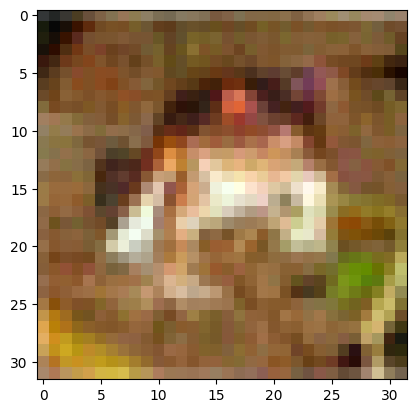

In [ ]:
plt.imshow(perturbed_images_1[0])

In [ ]:
sgd = optimizers.SGD(lr=0.001, momentum=0.9)

# For a multi-class classification problem
model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])


model.fit(np.array(perturbed_images_1) ,np.array(labels),epochs=25,validation_data=(x_val,y_val),batch_size=batch_size)
model.save('/content/drive/MyDrive/puja_phd/model_vgg16_raw_adverserial_training.h5')

Epoch 1/25
313/313 [==============================] - 21s 59ms/step - loss: 2.2806 - accuracy: 0.1313 - val_loss: 2.1465 - val_accuracy: 0.1700
Epoch 2/25
313/313 [==============================] - 18s 58ms/step - loss: 1.8632 - accuracy: 0.2336 - val_loss: 1.6693 - val_accuracy: 0.3202
Epoch 3/25
313/313 [==============================] - 18s 58ms/step - loss: 1.6034 - accuracy: 0.3336 - val_loss: 1.4211 - val_accuracy: 0.4009
Epoch 4/25
313/313 [==============================] - 18s 58ms/step - loss: 1.4295 - accuracy: 0.4381 - val_loss: 1.2497 - val_accuracy: 0.5405
Epoch 5/25
313/313 [==============================] - 18s 57ms/step - loss: 1.2513 - accuracy: 0.5442 - val_loss: 0.9529 - val_accuracy: 0.6601
Epoch 6/25
313/313 [==============================] - 18s 57ms/step - loss: 1.0575 - accuracy: 0.6242 - val_loss: 0.8473 - val_accuracy: 0.7123
Epoch 7/25
313/313 [==============================] - 18s 58ms/step - loss: 0.9331 - accuracy: 0.6735 - val_loss: 0.8974 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.cm as cm
def make_gradcam_heatmap(img_array, model, layerName='block4_conv3'):

    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layerName).output, model.output])
    img_array = np.expand_dims(img_array,axis=0)
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # if pred_index is None:
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds
def gradCAMImage(image,model,layerName='block4_conv3'):
    img=image

    heatmap,preds = make_gradcam_heatmap(image,model,layerName,)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(np.uint8(255*img), 0.8, heatmap, 0.2, 0)
    # gradcam = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)


    return superimposed_img

In [ ]:
import cv2


In [ ]:
from tqdm import tqdm
# epsilon = 0.1  # Set the magnitude of the perturbation
model=tf.keras.models.load_model('/content/drive/MyDrive/puja_phd/vgg16_cifar10_raw.h5')
# Create lists to store the perturbed images and labels
perturbed_images1 = []
labels_1 = []
c=0
# Generate perturbed images for all test data
# x_train, y_train=train_x.next()

for image, label in tqdm(zip(x_train, y_train)):
  if c<=8000:
    # cam3 = GradCAM(model,'block5_conv3').compute_heatmap(image=image, classIdx=np.argmax(label), upsample_size=(32,32))
    new_img = gradCAMImage(image,model)
    # perturbed_image = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)

    #x_train= np.repeat(x_train, 3, axis=-1)
    perturbed_images1.append(new_img)
    labels_1.append(label)
    c+=1

  else:
    perturbed_images1.append(image)
    labels_1.append(label)


import pickle
with open('/content/drive/MyDrive/puja_phd/cifar_32_gradcam_image_withoutbgr_80_20.pkl', 'wb') as file:
  pickle.dump(perturbed_images1,file)

with open('/content/drive/MyDrive/puja_phd/cifar_32_gradcam_labels_withoutbgr_80_20.pkl', 'wb') as file:
  pickle.dump(labels_1,file)
# Convert the lists to NumPy arrays


40000it [06:07, 108.79it/s]


In [ ]:
# import pickle
# perturbed_images1=[]
# labels_1=[]
# with open('/content/drive/MyDrive/puja_phd/cifar_32_gradcam_image_withoutbgr_80_20.pkl', 'rb') as file:
#   perturbed_images1=pickle.load(file)

# with open('/content/drive/MyDrive/puja_phd/cifar_32_gradcam_labels_withoutbgr_80_20.pkl', 'rb') as file:
#   labels_1=pickle.load(file)

In [ ]:
# sgd = optimizers.SGD(lr=0.001, momentum=0.9)
# model=tf.keras.models.load_model('/content/drive/MyDrive/puja_phd/vgg16_cifar10_raw.h5')
# For a multi-class classification problem
model1.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])


model1.fit(np.array(perturbed_images1)/255. ,np.array(labels_1),epochs=80,validation_data=(x_val,y_val),batch_size=batch_size)
# model1.save('/content/drive/MyDrive/puja_phd/model_vgg16_raw_gradcam_training.h5')

Epoch 1/80


In [ ]:
model1.save('/content/drive/MyDrive/puja_phd/model_vgg16_raw_gradcam_training.h5')